# Data Analytics Portfolio: Python

In dit Notebook toon ik mijn kennis en vaardigheid van Python. Dit bestand is een aanvulling op `DataAnalyticsPortfolio_JoranBakker.docx`. Er komen 4 onderwerpen aan bod waarin ik data cleaning, data analyse en datavisualisatie zal doen. De syntax probeer ik altijd zo consistent en beknopt mogelijk te houden.

Libraries importeren.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas

### Analyse van luchthavens en vluchten
Ik zal een dataset van vluchten opschonen en missende data invullen in een dataset van vliegvelden.

CSV bestand importeren.

In [2]:
flights = pd.read_csv('vluchten.csv')

In [3]:
flights.tail()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,WHEELS_OFF,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON
112071,2015,12,31,4,DL,984,N6702,ATL,JFK,2045,...,2105.0,95.0,760,10.0,2306,2250.0,-16.0,0,0,NaN
112072,2015,12,31,4,AS,24,N492AS,SEA,BOS,2130,...,2140.0,295.0,2496,4.0,545,539.0,-6.0,0,0,NaN
112073,2015,12,31,4,B6,230,N249JB,RSW,JFK,2150,...,2154.0,130.0,1074,6.0,23,10.0,-13.0,0,0,NaN
112074,2015,12,31,4,DL,1812,N3730B,ATL,ORD,2221,...,2232.0,84.0,606,6.0,2319,2302.0,-17.0,0,0,NaN
112075,2015,12,31,4,UA,1430,N17104,OGG,DEN,2300,...,2300.0,370.0,3302,7.0,845,817.0,-28.0,0,0,NaN


Kijken of er data mist in de DESTINATION_AIRPORT kolom.

In [4]:
flights['DESTINATION_AIRPORT'].isna().sum()

4723

Het percentage ontbrekende aankomstvliegvelden printen.

In [5]:
print(round((flights['DESTINATION_AIRPORT'].isna().sum() / len(flights['DESTINATION_AIRPORT'])) * 100, 1), '%')

4.2 %


Rijen verwijderen waar DESTINATION_AIRPORT NaN is.

In [6]:
flights.dropna(subset=['DESTINATION_AIRPORT'], inplace=True)

Tellen hoeveel rijen de dataset nu heeft.

In [7]:
len(flights)

107353

Unieke waarden van kolom tonen, zodat ik daarna de gecancelde vluchten kan verwijderen.

In [8]:
set(flights['CANCELLED'])

{0, 1}

Controleren of de waarde `1` inderdaad de gecancelde vluchten vertegenwoordigen.

In [9]:
(flights['CANCELLED'] == 1).sum()

1732

Gecancelde vluchten verwijderen.

In [10]:
flights = flights[flights['CANCELLED'] == 0]

Het aantal overgebleven datapunten printen.

In [11]:
len(flights)

105621

Andere dataset inladen.

In [12]:
airports = pd.read_csv('vliegvelden.csv')

In [13]:
airports.tail()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
314,WRG,Wrangell Airport,Wrangell,AK,USA,56.48433,-132.36982
315,WYS,Westerly State Airport,West Yellowstone,MT,USA,44.68840,-111.11764
316,XNA,Northwest Arkansas Regional Airport,Fayetteville/Springdale/Rogers,AR,USA,36.28187,-94.30681
317,YAK,Yakutat Airport,Yakutat,AK,USA,59.50336,-139.66023
318,YUM,Yuma International Airport,Yuma,AZ,USA,32.65658,-114.60597


Kijken of er ergens in de dataset (een gedeelte van) een coördinaat mist.

In [14]:
airports[airports['LATITUDE'].isna() | airports['LONGITUDE'].isna()]

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
276,SFO,San Francisco International Airport,San Francisco,CA,USA,NaN,NaN


De ontbrekende coördinaten opzoeken en toevoegen aan de dataset.

In [15]:
# Google maps: 37.6191671,-122.3841857
airports.loc[airports['AIRPORT'] == 'San Francisco International Airport', 'LATITUDE'] = airports.loc[airports['AIRPORT'] == 'San Francisco International Airport', 'LATITUDE'].fillna(37.61917)

In [16]:
airports.loc[airports['AIRPORT'] == 'San Francisco International Airport', 'LONGITUDE']= airports.loc[airports['AIRPORT'] == 'San Francisco International Airport', 'LONGITUDE'].fillna(-122.38419)

Rij controleren.

In [17]:
airports[airports['AIRPORT'] == 'San Francisco International Airport']

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
276,SFO,San Francisco International Airport,San Francisco,CA,USA,37.61917,-122.38419


Per aankomstvliegveld uitrekenen hoeveel vluchten daar zijn geland. Eerst maak ik een primary key kolom aan voor het `flights` dataframe, omdat er nu nog geen kolom is die enkel unieke waarden heeft.

In [18]:
flights['ID'] = range(1, len(flights) +1)

Dataframe groeperen.

In [19]:
arrivalcount = flights.groupby('DESTINATION_AIRPORT')['ID'].count().reset_index().rename(columns={'ID': 'ARRIVALS'})
arrivalcount

,DESTINATION_AIRPORT,ARRIVALS
0,ATL,18194
1,AUS,2254
2,BET,46
3,BOI,599
4,BOS,5465
5,DEN,10114
6,ECP,236
7,HNL,2316
8,JFK,4718
9,LAS,6876


Dataframes joinen en rijen met NaN verwijderen.

In [20]:
df = airports.join(arrivalcount.set_index('DESTINATION_AIRPORT'), on='IATA_CODE').dropna()
df

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE,ARRIVALS
20,ATL,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,USA,33.64044,-84.42694,18194.0
22,AUS,Austin-Bergstrom International Airport,Austin,TX,USA,30.19453,-97.66987,2254.0
27,BET,Bethel Airport,Bethel,AK,USA,60.77978,-161.83800,46.0
38,BOI,Boise Airport (Boise Air Terminal),Boise,ID,USA,43.56444,-116.22278,599.0
39,BOS,Gen. Edward Lawrence Logan International Airport,Boston,MA,USA,42.36435,-71.00518,5465.0
85,DEN,Denver International Airport,Denver,CO,USA,39.85841,-104.66700,10114.0
140,HNL,Honolulu International Airport,Honolulu,HI,USA,21.31869,-157.92241,2316.0
165,JFK,John F. Kennedy International Airport (New Yor...,New York,NY,USA,40.63975,-73.77893,4718.0
173,LAS,McCarran International Airport,Las Vegas,NV,USA,36.08036,-115.15233,6876.0
181,LGA,LaGuardia Airport (Marine Air Terminal),New York,NY,USA,40.77724,-73.87261,4984.0


Met seaborn en de geopandas libary zal ik de dataset plotten die ik hierboven heb gemaakt. Op de kaart worden de locaties van vliegvelden getoond. De map met shape bestanden komt vanuit Bit Academy.

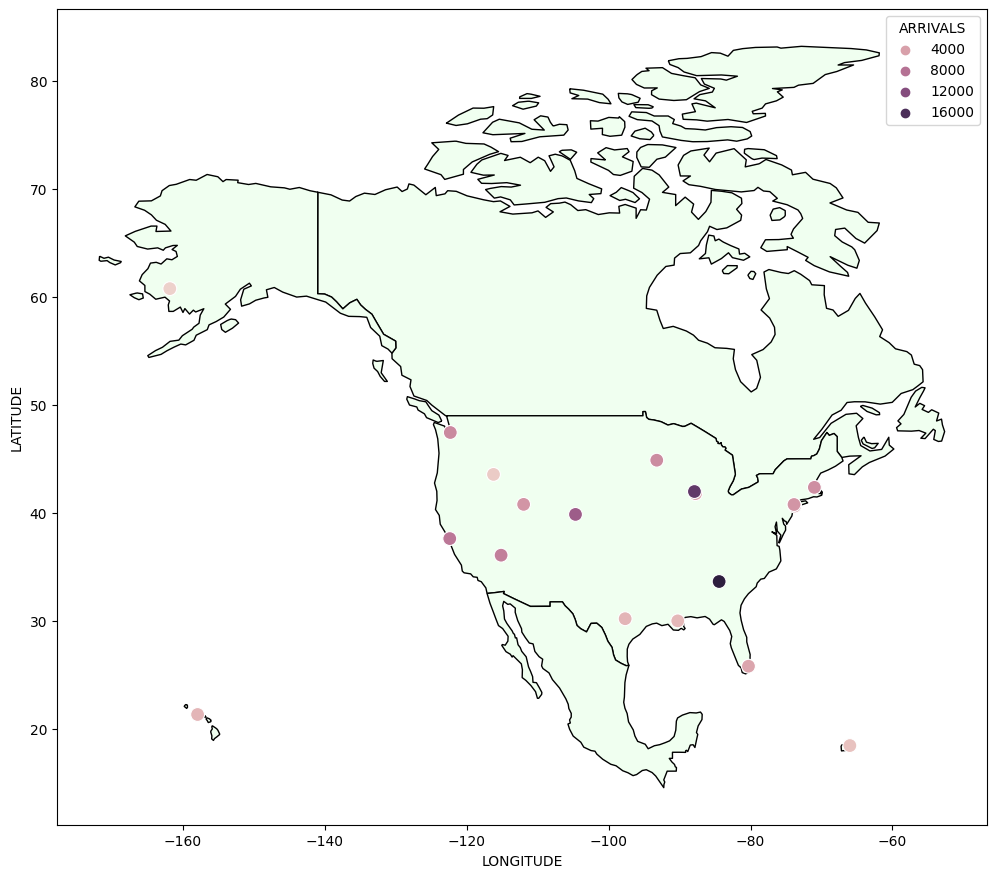

In [21]:
world = geopandas.read_file("worldmap/worldmap.shp")
filtered_world = world[world['SOVEREIGNT'].isin(["Canada", "United States of America", "Mexico"])]

f, ax = plt.subplots(1, figsize=(12, 12))
ax = filtered_world.plot(color='honeydew', edgecolor='black', ax=ax)
sns.scatterplot(data=df, x=df['LONGITUDE'], y=df['LATITUDE'], s=100, hue=df['ARRIVALS'])
plt.show()

### Analyse van huurprijzen in India

Hieronder maak ik een scatterplot, 2 boxplots en een lineplot over huurprijzen.

CSV in dataframe zetten.

In [22]:
rent = pd.read_csv('india_prices.csv')

Dataframe bekijken zodat ik weet hoe de kolommen heten en wat de inhoud is.

In [23]:
rent.tail()

,Unnamed: 0,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,State
4119,2828,2022-07-10,3,38000,1300,9 out of 19,Carpet Area,"Chromepet, GST Road",Chennai,Unfurnished,Bachelors/Family,3,Contact Agent,2
4120,3389,2022-07-10,3,12000,1250,2 out of 6,Carpet Area,Alwal,Hyderabad,Furnished,Family,3,Contact Owner,3
4121,3042,2022-07-10,3,40000,1400,3 out of 5,Carpet Area,Nandambakkam,Chennai,Furnished,Bachelors/Family,3,Contact Agent,3
4122,2583,2022-07-10,2,17500,1200,2 out of 2,Carpet Area,Anna Nagar West,Chennai,Furnished,Bachelors/Family,2,Contact Owner,2
4123,2984,2022-07-11,2,12000,550,Ground out of 1,Super Area,Choolaimedu,Chennai,Unfurnished,Bachelors/Family,2,Contact Owner,1


Scatterplot maken.

Text(0, 0.5, 'Huur (INR)')

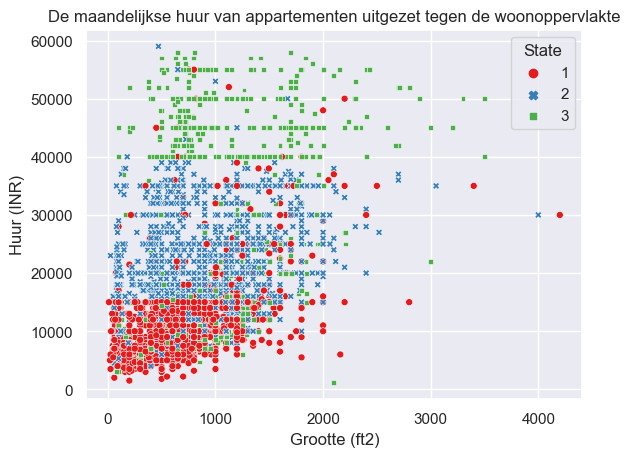

In [24]:
sns.set_theme()
sns.scatterplot(data=rent, x='Size', y='Rent', s=25, hue='State', style='State', palette='Set1')
plt.title('De maandelijkse huur van appartementen uitgezet tegen de woonoppervlakte')
plt.xlabel('Grootte (ft2)')
plt.ylabel('Huur (INR)')

Er is te zien dat de huurprijzen sterk correleren met de staat van de woning, omdat de kleuren ofwel categorieën duidelijk horizontaal zijn gescheiden in de visualisatie.

Nu is ook duidelijk dat hoe hoger de waarde van `State` is, hoe beter de staat van de woning is.

Boxplot maken.

In [25]:
rent[rent['State'].isin([1,3])]

,Unnamed: 0,Posted On,BHK,Rent,Size,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact,State
1,243,2022-04-23,2,7000,450,1 out of 3,Carpet Area,safuipara,Kolkata,Furnished,Bachelors,2,Contact Owner,1
2,53,2022-04-23,2,15000,1000,Ground out of 2,Super Area,Bansdroni,Kolkata,Unfurnished,Bachelors/Family,2,Contact Owner,1
3,359,2022-04-23,1,15000,1000,2 out of 3,Super Area,Barrackpore,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1
4,417,2022-04-23,1,6500,800,Ground out of 1,Carpet Area,Santragachi,Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1
5,398,2022-04-23,2,8000,650,1 out of 2,Super Area,"Garia Station, Garia",Kolkata,Unfurnished,Bachelors/Family,1,Contact Owner,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4112,3375,2022-07-10,3,40000,1900,4 out of 5,Carpet Area,"Himayath Nagar, NH 7",Hyderabad,Furnished,Bachelors/Family,3,Contact Agent,3
4113,3402,2022-07-10,1,14500,500,2 out of 5,Carpet Area,Kondapur,Hyderabad,Furnished,Bachelors,1,Contact Agent,3
4120,3389,2022-07-10,3,12000,1250,2 out of 6,Carpet Area,Alwal,Hyderabad,Furnished,Family,3,Contact Owner,3
4121,3042,2022-07-10,3,40000,1400,3 out of 5,Carpet Area,Nandambakkam,Chennai,Furnished,Bachelors/Family,3,Contact Agent,3


Text(0, 0.5, 'Huur (INR)')

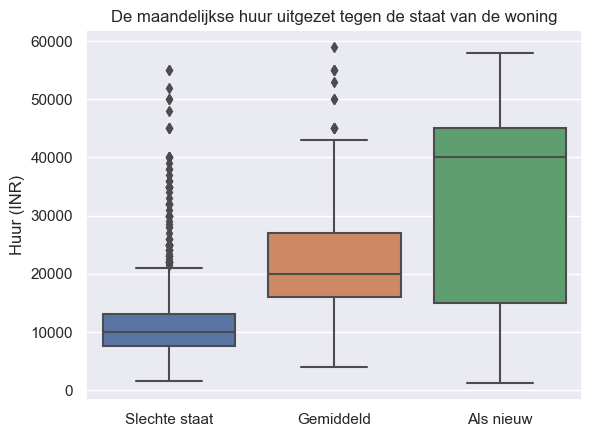

In [26]:
sns.boxplot(data=rent, x='State', y='Rent')
plt.title('De maandelijkse huur uitgezet tegen de staat van de woning')
plt.xlabel('')
plt.xticks(ticks= [0,1,2], labels= ['Slechte staat', 'Gemiddeld', 'Als nieuw'])
plt.ylabel('Huur (INR)')

De huurprijs mediaan van de woningen in gemiddelde staat, ligt net onder het 75e percentiel van de woningen die in slechte staat verkeren. Dit is ook het geval wanneer de woningen die als nieuw zijn, worden vergeleken met de woningen van gemiddelde staat.

Driekwart van de woningen in de categorieën `gemiddelde staat` en `als nieuw`, zijn duurder dan driekwart van de woningen met een `slechte staat`.

(0.0, 70000.0)

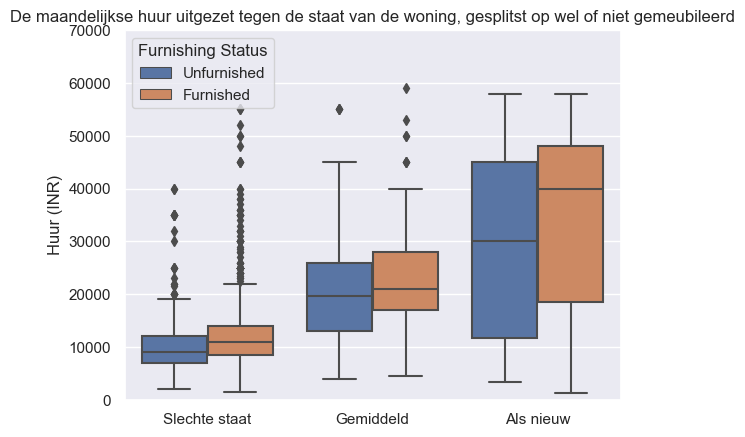

In [27]:
sns.boxplot(data=rent, x='State', y='Rent', hue='Furnishing Status')
plt.title('De maandelijkse huur uitgezet tegen de staat van de woning, gesplitst op wel of niet gemeubileerd')
plt.xlabel('')
plt.xticks(ticks= [0,1,2], labels= ['Slechte staat', 'Gemiddeld', 'Als nieuw'])
plt.ylabel('Huur (INR)')
plt.ylim(0, 70000)

Gemeulibleerde huizen hebben over het algemeen een hogere huurprijs. In de visualisatie hierboven liggen de oranje boxplots steeds hoger op de y-as dan de niet gemeubileerde woningen in het blauw.

Dataset groeperen op de kolom Posted On:

In [28]:
rentgroup = rent.groupby('Posted On')['BHK'].count().reset_index()
rentgroup.rename(columns={'BHK' : 'Aantal'})

,Posted On,Aantal
0,2022-04-23,7
1,2022-04-24,6
2,2022-04-25,6
3,2022-04-26,2
4,2022-04-27,13
...,...,...
75,2022-07-07,90
76,2022-07-08,62
77,2022-07-09,54
78,2022-07-10,46


Ik zal een lijngrafiek maken van het aantal huizen die zijn verhuurd in 2022.

Text(0, 0.5, '')

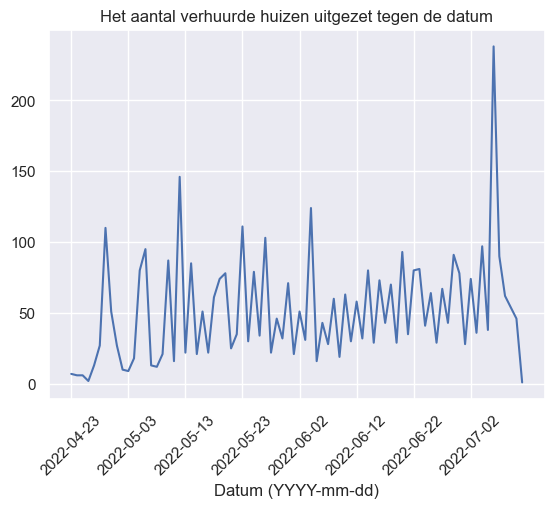

In [29]:
sns.lineplot(data=rentgroup, x='Posted On', y='BHK')
plt.xticks(rentgroup['Posted On'][::10], rotation=45)
plt.title('Het aantal verhuurde huizen uitgezet tegen de datum')
plt.xlabel('Datum (YYYY-mm-dd)')
plt.ylabel('')

### Analyse van bulldozers
Ik zal een dataset over bulldozers opschonen en daar een histogram en scatterplot over maken.

In [30]:
bd = pd.read_csv('data.csv')

In [31]:
bd.tail()

,SalesID,SalePrice,MachineID,YearMade,saledate,MachineHoursCurrentMeter,ProductGroup,ProductSize
142634,6319998,55000,1831997,1999,12/14/2011 0:00,24.0,WL,Medium
142635,6320871,15200,1827657,2006,12/14/2011 0:00,24.0,SSL,NaN
142636,6321495,11200,1925538,1000,9/10/2011 0:00,2196.0,MG,NaN
142637,6321692,13000,1920012,2008,12/14/2011 0:00,24.0,SSL,NaN
142638,6331198,30700,1867348,2005,11/30/2011 0:00,1120.0,TEX,Mini


<AxesSubplot: xlabel='YearMade', ylabel='Count'>

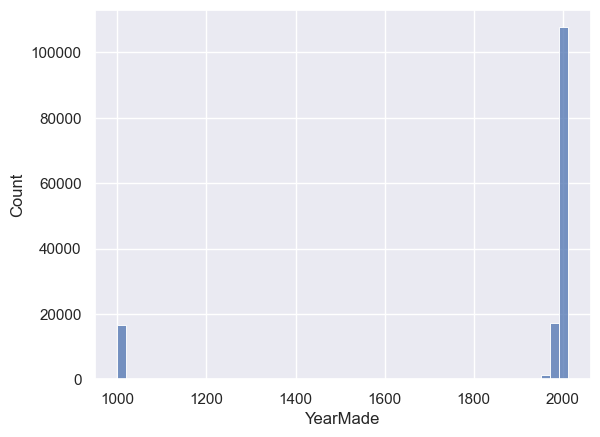

In [32]:
sns.histplot(data=bd, x='YearMade', bins=50)

Er is te zien dat er rijen zijn met een onjuist bouwjaar. Ik wil weten hoeveel dit er zijn en ze vervolgens verwijderen.

In [33]:
len(bd[bd['YearMade'] < 1500])

16473

In [34]:
bd = bd[bd['YearMade'] > 1500]

Ik plot de data opnieuw, maar nu met valide bouwjaren.

<AxesSubplot: xlabel='YearMade', ylabel='Count'>

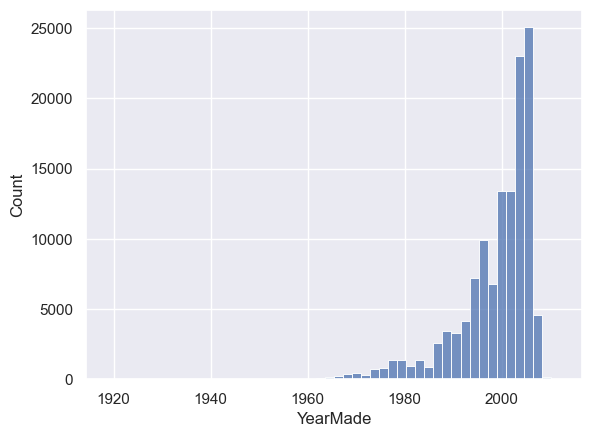

In [35]:
sns.histplot(data=bd, x='YearMade', bins=50)

Kolom naar datetime type casten.

In [36]:
bd['saledate'] = pd.to_datetime(bd['saledate'])

Jaar extraheren uit de kolom.

In [37]:
bd['SalesYear'] = bd['saledate'].dt.year

Leeftijd berekenen en in nieuwe kolom zetten.

In [38]:
bd['Age'] = bd['SalesYear'] - bd['YearMade']

Nu maak ik een scatterplot, om de correlatie te zien tussen de prijs van bulldozers en de leeftijd.

Text(0.5, 1.0, 'De prijs van bulldozers uitgezet tegen de leeftijd')

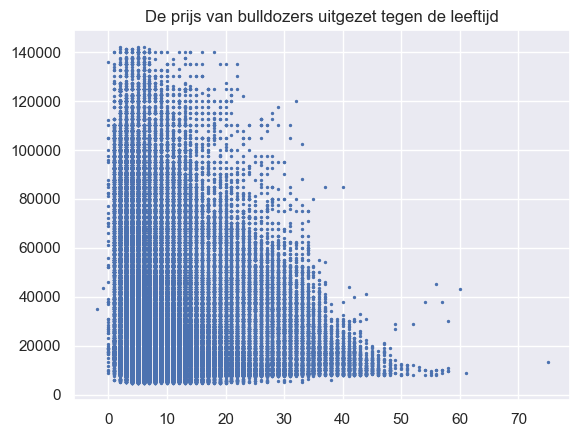

In [39]:
plt.scatter(data=bd, x='Age', y='SalePrice', s=2)
plt.title('De prijs van bulldozers uitgezet tegen de leeftijd')

### Analyse van reviewscores per genre
Ik zal een film dataset uit IMDB opschonen en analyseren.

CSV importeren.

In [40]:
imdb = pd.read_csv('movies.csv', index_col='index')

In [41]:
imdb.tail()

,title,year,date_published,genre,duration,language,description,reviews_from_users,reviews_from_critics
index,,,,,,,,,
34247,Harlem Aria,1999,1999-09-12,Drama,100,English,"Chasing his dream, Anton leaves his aunt's hom...",5.0,8.0
34517,Kvar,1978,1978-12-16,Drama,91,Serbo-Croatian,"A journalist lives his smooth citizen life, ma...",NaN,1.0
31181,Ça reste entre nous,1998,1998-05-06,Comedy,86,French,"Patrick loves his exquisite wife, who made him...",NaN,1.0
37570,Anyád! A szúnyogok,2000,2000-02-10,Comedy,80,Hungarian,NaN,2.0,2.0
59929,Dârin wa gaikokujin,2010,2010-04-10,Comedy,100,Japanese,"Set in the Tokyo area, an aspiring Japanese ma...",8.0,10.0


Aantal rijen printen.

In [42]:
len(imdb)

21782

Duplicaten verwijderen.

In [43]:
imdb = imdb.drop_duplicates()

In [44]:
len(imdb)

21770

Duplicaten tellen die zijn verwijderd.

In [45]:
print(21782 - 21770, 'duplicaten, of', round(((21782 - 21770) / 21782) * 100, 2), '%')

12 duplicaten, of 0.06 %


Alle unieke genres tonen in de dataset.

In [46]:
set(imdb['genre'])

{'Adventure',
 'Comedy',
 'Drama',
 'Romance',
 'Sci Fi',
 'Sci-Fi',
 'SciFi',
 'Science Fiction',
 'Western',
 'sci-fi'}

Sci-Fi staat er op 4 verschillende manieren in. Ik ga ervoor zorgen dat dit consistent wordt gespeld, zodat we later kunnen aggregeren op deze kolom.

In [47]:
imdb['genre'] = imdb['genre'].replace(to_replace=['Sci Fi', 'SciFi', 'sci-fi', 'Science Fiction'], value='Sci-Fi')

Controleren of de genres nu wel kloppen.

In [48]:
set(imdb['genre'])

{'Adventure', 'Comedy', 'Drama', 'Romance', 'Sci-Fi', 'Western'}

De gemiddelde reviewscore per genre berekenen.

In [49]:
imdb_grouped = imdb.groupby('genre')['reviews_from_users'].mean().round(1).reset_index()
imdb_grouped

,genre,reviews_from_users
0,Adventure,9.7
1,Comedy,17.0
2,Drama,16.6
3,Romance,9.2
4,Sci-Fi,18.7
5,Western,19.0


In [50]:
print('Het hoogste gemiddelde is voor Western films:', imdb_grouped.loc[5, 'reviews_from_users'])

Het hoogste gemiddelde is voor Western films: 19.0
